In [1]:
import numpy as np
import pickle
import pandas as pd

import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from ml_utils import models, tools
from baumhofer_utils import *

from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
from IPython.display import clear_output

## Data import and cleaning


In [2]:
# Load the data we will need
with open("./data/X_array_first_100.pkl", "rb") as a_file:
    X = pickle.load(a_file)

with open("./data/index_first_100.pkl", "rb") as a_file:
    index = pickle.load(a_file)

with open("./data/capacity_target_df_first_100.pkl", "rb") as a_file:
    cap_df = pickle.load(a_file)

with open("./data/y_array_first_100.pkl", "rb") as a_file:
    y_arr = pickle.load(a_file)
    
with open("./data/y_IR_baumhofer_for_one_cycle.pkl", 'rb') as a_file:
    y_IR = pickle.load(a_file)

# Change the path for this one so it points to your local copy - too big for GitHub
with open("./data/baumhofer_first_100_cycles.pkl", "rb") as a_file:
    data = pickle.load(a_file)

del a_file

In [3]:
cells = list(data.keys())

index_cells = np.array([name.split("_")[0] for name in index])

In [4]:
# A function to reshape the data so it's the appropriate shape for 1D CNN / LSTM models.
# This will accept arbitrary numbers of features

def reshape_for_model(X_arr, to_plot=False):
    # Get the shape of the data prior to reshaping for model
    features, samples, timesteps = X_arr.shape
    
    # Instead of creating a new array where we assume a number of features,
    # we stack all features present in X_arr.
    X_reshaped = np.array([np.vstack(
                            [np.vstack(
                                [X_arr[j, i, :] for j in range(features)]
                            )]).T
                           for i in range(samples)])
        
    if to_plot:
        # Plot a random selection of instances to check they look OK
        indices = np.random.randint(0, samples, size=25)
        fig, ax = plt.subplots(5,5)
        for subplot, sample in enumerate(indices):
            ax.flatten()[subplot].plot(X_reshaped[sample,:,1])

        plt.show()
        
    return X_reshaped


X = reshape_for_model(X, to_plot=False)

Train test split

In [6]:
# Keep a test set back and use the rest for k-fold
train_cells, test_cells = train_test_split(cells, train_size=0.8, random_state=31)

train_cells_IR = train_cells.copy()
test_cells_IR = test_cells.copy()

# cell 30 has no IR so we remove it from the IR index
if '030' in test_cells:
    test_cells_IR.remove('030')
else:
    train_cells_IR.remove('030')
    
train_cells = np.array(train_cells)
test_cells = np.array(test_cells)

train_cells_IR = np.array(train_cells_IR)
test_cells_IR = np.array(test_cells_IR)





index_train = np.in1d(index_cells, train_cells)
index_test = np.in1d(index_cells, test_cells)

index_train_IR = np.in1d(index_cells, train_cells_IR)
index_test_IR = np.in1d(index_cells, test_cells_IR)




X_train, X_test = X[index_train], X[index_test]
X_train_IR, X_test_IR = X[index_train_IR], X[index_test_IR]

y_train, y_test = y_arr[index_train], y_arr[index_test]
y_train_IR, y_test_IR = y_IR[index_train_IR], y_IR[index_test_IR]

# Get the index arrays for k-fold
X_train_index = np.array([val for val in index_cells if val in train_cells])
X_test_index = np.array([val for val in index_cells if val in test_cells])

X_train_index_IR = np.array([val for val in index_cells if val in train_cells_IR])
X_test_index_IR = np.array([val for val in index_cells if val in test_cells_IR])

In [7]:
X_train_sc, _, X_test_sc = scaler_3d(X_train, X_test, X_test, scaler_type='robust', return_scaler=False)

X_train_sc_IR, _, X_test_sc_IR = scaler_3d(X_train_IR, X_test_IR, X_test_IR, scaler_type='robust', return_scaler=False)

## Functions for testing models

In [8]:
def train_nn_model(X, y, model, batch_size=512, epochs=200, callback=True):
    
    if callback:        
        callbacks = [LearningRateScheduler(tools.lr_scheduler, verbose=0)]
    else:
        callbacks = []
    
    model.fit(X,y,
              batch_size=batch_size,
              epochs=epochs,    
              shuffle=True,
              callbacks=callbacks,
              verbose=0)
    
    return model



import scipy.stats as stats

def calculate_CI(mean, variance, confidence_level=0.95):
    tail_prob = (1 - confidence_level)/2
    
    upper_z = stats.norm.ppf(1-tail_prob)

    return np.sqrt(variance) * upper_z


def calc_evaluation_metrics(model, X_train, y_train, X_test, y_test):
    mape_train = model.evaluate(X_train, y_train)[1]
    mape_test = model.evaluate(X_test, y_test)[1]
    
    rmse_train =  np.sqrt(mean_squared_error(y_train, model.predict(X_train).flatten()))
    rmse_test =  np.sqrt(mean_squared_error(y_test, model.predict(X_test).flatten()))
    
    return mape_train, mape_test, rmse_train, rmse_test


def train_and_evaluate_model(X_train, y_train, X_test, y_test):
    
    # Create model instance explicitly
    model = models.build_convnet_model(X_in=X_train, loss='mse', n_outputs=1)
    train_nn_model(X_train, y_train, model, batch_size=512, epochs=200, callback=True)

    metrics = calc_evaluation_metrics(model, X_train, y_train, X_test, y_test)
    print(metrics)
    clear_output() # remove this if you want loads of stuff printed out
    
    return model, metrics


def print_metrics(model_dict, data_type, target_name):
    
    if data_type.lower() == "capacity" or data_type.upper() == "IR":
        train_scores = np.array(model_dict[data_type][target_name]['train_scores'])
        test_scores = np.array(model_dict[data_type][target_name]['test_scores'])
        
        mean_train_MAPE, mean_train_RMSE = np.mean(train_scores, axis=0)
        mean_test_MAPE, mean_test_RMSE = np.mean(test_scores, axis=0)
        
        var_train_MAPE, var_train_RMSE = np.var(train_scores, axis=0)
        var_test_MAPE, var_test_RMSE = np.var(test_scores, axis=0)
        
        
        
        print(f"Average evaluation metrics for {data_type} target: {target_name}")
        print('       --------------------------------')
        print('      | Mean train RMSE | %s +-  %s |' % (float('%.2g'% mean_train_RMSE), float('%.4g'% calculate_CI(mean_train_RMSE, var_train_RMSE))))
        print('       --------------------------------')
        print('      | Mean test RMSE  | %s +- %s |' % (float('%.2g'% mean_test_RMSE), float('%.4g'% calculate_CI(mean_test_RMSE, var_test_RMSE))))
        print('       --------------------------------')
        print('      | Mean train MAPE |  %s +- %s |' % (float('%.2g'% mean_train_MAPE), float('%.4g'% calculate_CI(mean_train_MAPE, var_train_MAPE))))
        print('       --------------------------------')
        print('      | Mean test MAPE  |  %s +- %s |' % (float('%.2g'% mean_test_MAPE), float('%.4g'% calculate_CI(mean_test_MAPE, var_test_MAPE))))
        print('       --------------------------------')

## Testing models

In [22]:
# Create a dictionary structure to store the trained models and scores
data_types = ['capacity', 'IR']
targets = ['tto', 'ttp', 'tte']

model_dict = {var:
              {target:
               {'models': [], 'train_scores': [], 'test_scores': []}
               for target in targets}
              for var in data_types}

del data_types

In [23]:
# Specify the number of times to train and evaluate each model
n_iterations = 20 # set to 3 for speed during development

for target_idx, target_name in enumerate(targets): # define how many targets you want to examine
    for i in range(n_iterations):
        print(f"Running for target index {target_idx}: {target_name}")
        print(f"Iteration {i+1}")
        model, metrics = train_and_evaluate_model(X_train, y_train[:, target_idx], 
                                                  X_test, y_test[:, target_idx])

        # Split the metrics into individual variables
        train_MAPE, test_MAPE, train_RMSE, test_RMSE = metrics

        # Store the trained models and scores in the dictionary
        model_dict['capacity'][target_name]['models'] = model
        model_dict['capacity'][target_name]['train_scores'].append([train_MAPE, train_RMSE])
        model_dict['capacity'][target_name]['test_scores'].append([test_MAPE, test_RMSE])

In [25]:
for target in targets:
    print_metrics(model_dict, data_type='capacity', target_name=target)

Average evaluation metrics for capacity target: tto
       --------------------------------
      | Mean train RMSE | 120.0 +-  2.33 |
       --------------------------------
      | Mean test RMSE  | 88.0 +- 8.348 |
       --------------------------------
      | Mean train MAPE |  9.8 +- 0.2572 |
       --------------------------------
      | Mean test MAPE  |  8.7 +- 0.7996 |
       --------------------------------
Average evaluation metrics for capacity target: ttp
       --------------------------------
      | Mean train RMSE | 130.0 +-  4.027 |
       --------------------------------
      | Mean test RMSE  | 100.0 +- 10.07 |
       --------------------------------
      | Mean train MAPE |  8.6 +- 0.3027 |
       --------------------------------
      | Mean test MAPE  |  7.9 +- 0.7737 |
       --------------------------------
Average evaluation metrics for capacity target: tte
       --------------------------------
      | Mean train RMSE | 100.0 +-  3.207 |
       ---------

In [9]:
## IR

In [10]:
# Create a dictionary structure to store the trained models and scores
data_types = ['IR']
targets = ['tto', 'ttp']

model_dict = {var:
              {target:
               {'models': [], 'train_scores': [], 'test_scores': []}
               for target in targets}
              for var in data_types}

del data_types

In [12]:
# Specify the number of times to train and evaluate each model
n_iterations = 20 # set to 3 for speed during development

for target_idx, target_name in enumerate(targets): # define how many targets you want to examine
    for i in range(n_iterations):
        print(f"Running for target index {target_idx}: {target_name}")
        print(f"Iteration {i+1}")
        model, metrics = train_and_evaluate_model(X_train_IR, y_train_IR[:, target_idx], 
                                                  X_test_IR, y_test_IR[:, target_idx])

        # Split the metrics into individual variables
        train_MAPE, test_MAPE, train_RMSE, test_RMSE = metrics

        # Store the trained models and scores in the dictionary
        model_dict['IR'][target_name]['models'] = model
        model_dict['IR'][target_name]['train_scores'].append([train_MAPE, train_RMSE])
        model_dict['IR'][target_name]['test_scores'].append([test_MAPE, test_RMSE])

In [13]:
for target in targets:
    print_metrics(model_dict, data_type='IR', target_name=target)

Average evaluation metrics for IR target: tto
       --------------------------------
      | Mean train RMSE | 150.0 +-  3.75 |
       --------------------------------
      | Mean test RMSE  | 160.0 +- 13.34 |
       --------------------------------
      | Mean train MAPE |  11.0 +- 0.4377 |
       --------------------------------
      | Mean test MAPE  |  12.0 +- 0.7968 |
       --------------------------------
Average evaluation metrics for IR target: ttp
       --------------------------------
      | Mean train RMSE | 130.0 +-  5.165 |
       --------------------------------
      | Mean test RMSE  | 140.0 +- 9.873 |
       --------------------------------
      | Mean train MAPE |  7.6 +- 0.2659 |
       --------------------------------
      | Mean test MAPE  |  9.0 +- 0.5347 |
       --------------------------------


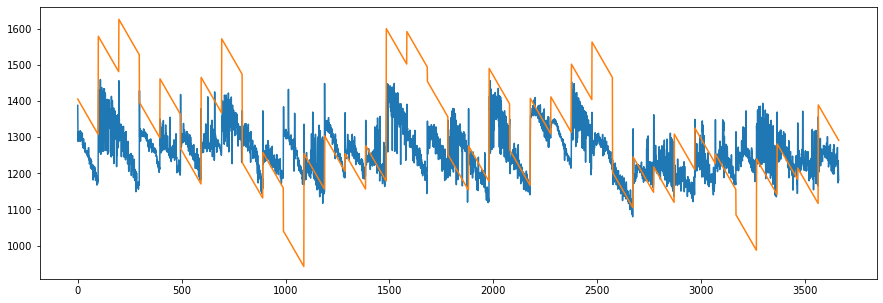

In [38]:
plt.figure(figsize=(15,5))

plt.plot(model_dict['IR']['ttp']['models'].predict(X_train_IR))
plt.plot(y_train_IR[:,1])

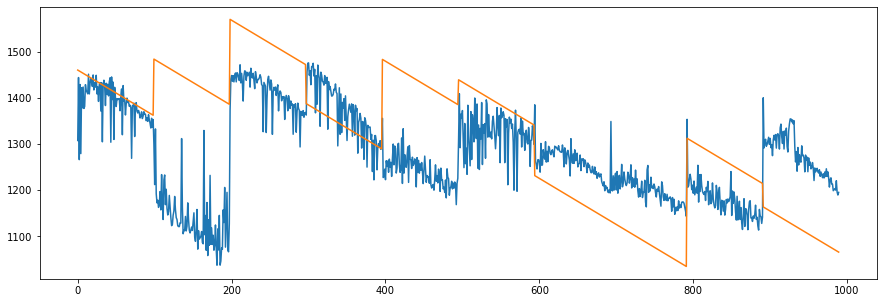

In [39]:
plt.figure(figsize=(15,5))

plt.plot(model_dict['IR']['ttp']['models'].predict(X_test_IR))
plt.plot(y_test_IR[:,1])

## Looking at data distribution

Text(0.5, 0, 'Elbow')

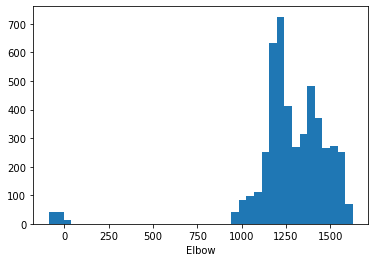

In [36]:
plt.hist(y_IR[:,1], 40)
plt.xlabel('Elbow')

In [42]:
len(y_IR)


4752

In [44]:
df_pen = sns.load_dataset("penguins")

In [56]:
df_elbows_knees

,0,1,2,3,4,5,6,7,8
0,1241.986944,1460.842091,0.005756,0.011935,885.888869,1134.898743,1170.0,0.231427,0.344207
1,1240.986944,1459.842091,0.005763,0.011943,884.888869,1133.898743,1169.0,0.231057,0.343837
2,1239.986944,1458.842091,0.005771,0.011951,883.888869,1132.898743,1168.0,0.230686,0.343467
3,1238.986944,1457.842091,0.005779,0.011959,882.888869,1131.898743,1167.0,0.230316,0.343097
4,1237.986944,1456.842091,0.005787,0.011966,881.888869,1130.898743,1166.0,0.229947,0.342727
...,...,...,...,...,...,...,...,...,...
4747,1084.869673,1295.699748,0.007340,0.012567,780.845598,1003.851810,1026.0,0.200832,0.318473
4748,1083.869673,1294.699748,0.007349,0.012576,779.845598,1002.851810,1025.0,0.200497,0.318138
4749,1082.869673,1293.699748,0.007358,0.012585,778.845598,1001.851810,1024.0,0.200163,0.317804
4750,1081.869673,1292.699748,0.007367,0.012594,777.845598,1000.851810,1023.0,0.199829,0.317470


In [58]:
df_elbows_knees = pd.DataFrame(np.append(y_IR, y_arr, 1),
                               columns=['tte-o', 'tte-p', 'IR@e-o', 'IR@e-p',
                                        'ttk-o', 'ttk-p', 'EOL', 'Q@k-o', 'Q@k-p'])

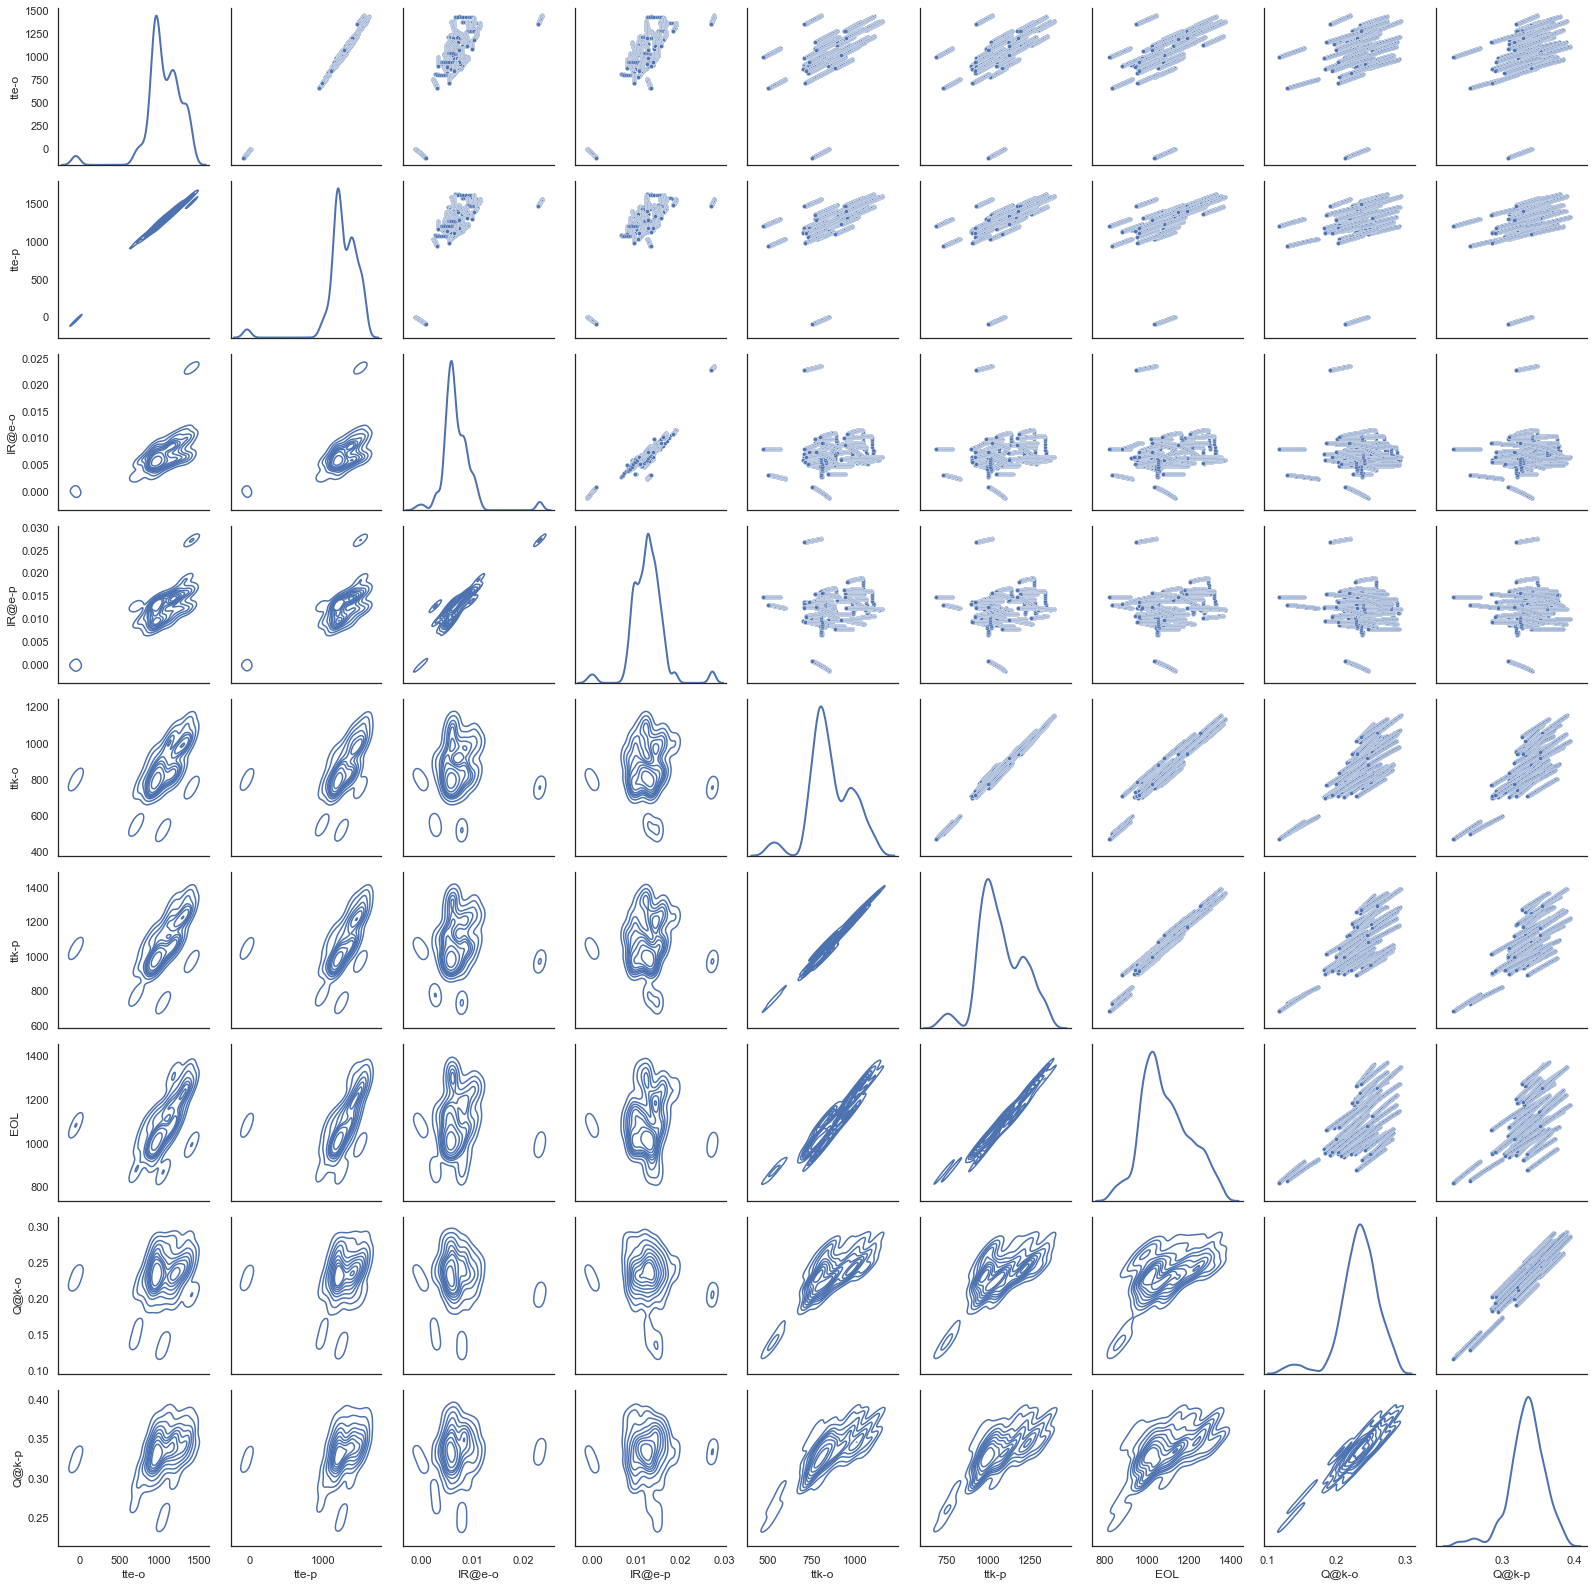

In [61]:
import seaborn as sns
sns.set_theme(style="white")


g = sns.PairGrid(df_elbows_knees, diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

In [67]:
g.savefig('./grid_plot.png')